In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Загрузка данных

In [2]:
train_data = pd.read_csv('data_toxic/toxic_train.csv', index_col=0)
test_data = pd.read_csv('data_toxic/toxic_test.csv', index_col=0)

Text(0.5, 1, 'Распределение классов в трейне')

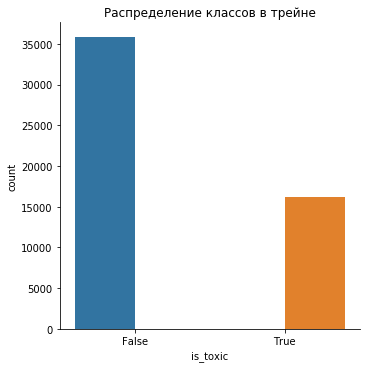

In [3]:
sns.catplot(x='is_toxic', data=train_data, hue='is_toxic', kind='count')
plt.title('Распределение классов в трейне')

In [4]:
target_train = train_data['is_toxic'].map({True : 1, False : -1})
train_data.drop(columns='is_toxic', inplace=True)

### 1. Приводим к нижнему регистру и заменяем все символы, не являющиеся буквами или цифрами на пробелы

In [5]:
train_data_processed_1 = train_data.copy()
test_data_processed_1 = test_data.copy()

In [6]:
import re

def text_process_1(texts_series):
    """
    Takes series with texts
    returns series with preprocessed texts
    (lower register + changed all symbols, which are not letter, number to spaces)
    """
    
    texts_series = texts_series.str.lower()
    texts_series = texts_series.apply(lambda x: re.sub(r'\W', ' ', x))
    return texts_series

In [7]:
train_data_processed_1 = text_process_1(train_data_processed_1['comment_text'])
test_data_processed_1 = text_process_1(test_data_processed_1['comment_text'])

### 2. Пользуемся CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
countVect = CountVectorizer(min_df=0.008)

In [10]:
train_data_processed_2 = countVect.fit_transform(train_data_processed_1)
test_data_processed_2 = countVect.transform(test_data_processed_1)

In [11]:
train_data_processed_2.shape[1]

692

In [12]:
import optimization
import scipy

Add bias

In [13]:
bias_feature_train = np.ones(train_data.shape[0])
bias_feature_test = np.ones(test_data.shape[0])
bias_feature_train = scipy.sparse.csr_matrix(bias_feature_train).T
bias_feature_test = scipy.sparse.csr_matrix(bias_feature_test).T
train_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_train, train_data_processed_2])
test_data_processed_2_with_bias = scipy.sparse.hstack([bias_feature_test, test_data_processed_2])

In [14]:
%%time
def experiment_cycle(train_data, target, classifier_type,
                     step_alpha_list, step_beta_list,
                     w_0_list, batch_size_list):
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
#                 print(step_alpha)
                clf = optimization.GDClassifier(step_alpha=step_alpha,
                                                    step_beta=step_beta, experiment=True)
                yield clf.fit(train_data,
                                target,
                                w_0=w_0,
                                trace=True)
                
    for step_alpha in step_alpha_list:
        for step_beta in step_beta_list:
            for w_0 in w_0_list:
                for batch_size in batch_size_list:
                    clf = optimization.SGDClassifier(step_alpha=step_alpha,
                                                     step_beta=step_beta,
                                                     experiment=True, max_iter=1000,
                                                     batch_size=batch_size)
                    yield clf.fit(train_data_processed_2,
                                  target,
                                  w_0=w_0,
                                  trace=True, log_freq=0.1)
                    


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.72 µs


In [15]:
train_data_processed_2.shape

(52061, 692)

## ВАЖНО! Все эксперименты будут проводиться с добавлением смещения в веса, которое не будет учитываться в регуляризации (чтобы даже в том случае, когда регуляризация занулит почти все веса, наша разделяющая гиперплоскость не вырождалась в 0)

In [91]:
import tqdm
history_list = []
step_alpha_list = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25]
# step_alpha_list = [0.1]
step_beta_list = [0, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25]
batch_size_list = [1, 128, 256, 512, 1024, 1024 * 4, 1024 * 10, 1024 * 20]
w_0_list = [None]
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values, 'SGD',
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

In [92]:
keys_for_df = ['time', 'func', 'accuracy']

In [93]:
len(history_list[0]['time']), len(history_list[0]['func']), len(history_list[0]['accuracy']),

(1001, 1001, 1001)

In [94]:
history_list[50]['classifier_type'], history_list[30]['step_alpha']

('GD', 1)

In [95]:
hist_0_df = pd.DataFrame({key: history_list[29][key] for key in keys_for_df})
hist_1_df = pd.DataFrame({key: history_list[300][key] for key in keys_for_df})

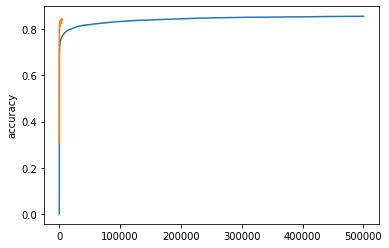

In [96]:
sns.lineplot(x = np.cumsum(np.arange(len(hist_0_df['accuracy']))), y=hist_0_df['accuracy'])
sns.lineplot(x = np.cumsum(np.arange(len(hist_1_df['accuracy']))), y=hist_1_df['accuracy'])
# plt.semilogy()

In [97]:
import pickle
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'wb') as f:
    pickle.dump(history_list, f)

## Эксперименты с различными начальными приближениями:
https://datascience.stackexchange.com/questions/30989/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero
###   Рассмотрим 6 экспериментов: 
1) w_0 = 0
2) w_0 = uniform(0, 1)
3) w_0 = uniform(100, 500)
4) w_0 = uniform(1000, 5000)
5) w_0 = uniform (10000, 50000)
6) w_0 = normal with mean = 0, std = 1

In [33]:
w_0_list = []
w_0_list.append(np.zeros(train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(0, 1, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(100, 500, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(1000, 5000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.uniform(10000, 50000, size=train_data_processed_2_with_bias.shape[1]))
w_0_list.append(np.random.normal(0, 1, size=train_data_processed_2_with_bias.shape[1]))

###  Выберем лучшие параметры из прошлого эксперимента:

In [60]:
import pickle 
history_list = []
with open('GD_SGD_step_alpha_beta_batch_size.pkl', 'rb') as f:
    history_list = pickle.load(f)

In [61]:
max_acc = 0
arg_max = 0
for i, history in enumerate(history_list):
    if np.max(history['accuracy']) > max_acc:
        max_acc = np.max(history['accuracy'])
        arg_max = i
    

In [62]:
print(history_list[arg_max]['step_alpha'],
      history_list[arg_max]['step_beta'])

10 0.1


In [59]:
import tqdm
history_list = []
step_alpha_list = [h]
# step_alpha_list = [0.1]
step_beta_list = [0, 0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 25]
batch_size_list = [1, 128, 256, 512, 1024, 1024 * 4, 1024 * 10, 1024 * 20]
w_0_list = [None]
for history in tqdm.tqdm_notebook(experiment_cycle(train_data_processed_2_with_bias, target_train.values, 'SGD',
                                step_alpha_list,
                                step_beta_list,
                                w_0_list=w_0_list,
                                batch_size_list=batch_size_list)):
    history_list.append(history)

0.8786734105896664

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/paniquex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
lemmatizer = nltk.WordNetLemmatizer() 

In [23]:
train_data_processed_1

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159494        our previous conversation   you fucking sh...
159514                    you are a mischievious pubic hair
159541    your absurd edits   your absurd edits on great...
159546       hey listen don t you ever     delete my edi...
159554    and i m going to keep posting the stuff u dele...
Name: comment_text, Length: 52061, dtype: object

In [24]:
%%time
train_data_processed_lemmatized = train_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])
test_data_processed_lemmatized = test_data_processed_1.apply(lambda x: x.split()).apply(lambda x: [lemmatizer.lemmatize(elem) for elem in x])

CPU times: user 11.7 s, sys: 84 ms, total: 11.8 s
Wall time: 11.8 s


In [25]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
%%time
train_data_processed_3 = train_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
train_data_processed_3 = train_data_processed_3.apply(lambda x: ' '.join(x))

test_data_processed_3 = test_data_processed_lemmatized.apply(lambda x: [elem for elem in x if elem not in stopwords_set])
test_data_processed_3 = test_data_processed_3.apply(lambda x: ' '.join(x))

CPU times: user 362 ms, sys: 3.99 ms, total: 366 ms
Wall time: 366 ms


In [27]:
%%time
countVect.fit_transform(train_data_processed_3)

CPU times: user 1.15 s, sys: 3.99 ms, total: 1.15 s
Wall time: 1.15 s


<52061x580 sparse matrix of type '<class 'numpy.int64'>'
	with 673750 stored elements in Compressed Sparse Row format>